In [ ]:
#finetune_roberta.py

In [1]:
import pandas as pd
json_file_path = './merged_int_SRS_df_op1_2nd_1004_Nov04F2.json'
merged_int_SRS_df = pd.read_json(json_file_path, orient='records', lines=True)

In [ ]:
# option1 : 2nd High Vs ASD

In [2]:
# Define label mapping
label_mapping = {'TD': 0, 'High': 1, 'ASD': 2}

# Preprocess the dataset 4 tasks #'Played catch_new', 'Fed baby doll_new','Reacted to snack_new', 
def preprocess_function_2(row):
    # task_results = f"1. Name calling response: {row['Responded to name_new2']} 2. Mimicked actions: {row['Mimicked actions1_new2'] + row['Mimicked actions2_new2']} 4. Played catch: {row['Played catch_new2']} 5. Fed baby doll: {row['Fed baby doll_new2']} 6. Reacted to snack: {row['Reacted to snack_new2']}"
    task_results = f" {row['Responded to name_new2']} ,{row['Mimicked actions1_new2'] + row['Mimicked actions2_new2']} ,{row['Played catch_new2']} ,{row['Fed baby doll_new2']} ,{row['Reacted to snack_new2']}"
    input_text = f"Task Results: {task_results} Combined: {row['combined']}"
    label = label_mapping[row['Class_ex']]
    return {"SubjectId": row['SubjectId'], "text": input_text, "label": label}

preprocessed_2 = merged_int_SRS_df.apply(preprocess_function_2, axis=1)
preprocessed_df2 = pd.DataFrame(preprocessed_2.tolist())

# Check if the 'SubjectId', 'text', and 'label' columns are created correctly
# print(preprocessed_df[['SubjectId','text', 'label']].head())
print(preprocessed_df2[['SubjectId','text', 'label']].head())

    SubjectId                                               text  label
0  1023032801  Task Results:  Success of Responded to name ,S...      0
1  1023040831  Task Results:  Success of Responded to name ,F...      2
2  1023041001  Task Results:  Success of Responded to name ,S...      2
3  1023041311  Task Results:  Success of Responded to name ,S...      0
4  1023041701  Task Results:  Success of Responded to name ,F...      2


In [3]:

df_sF= preprocessed_df2[['SubjectId','text', 'label']]
df_sF.columns=['SubjectId','text','Class']

In [4]:
df_sF['label'] = df_sF['Class']
df_sF.label.value_counts()

label
2    353
0    188
1    162
Name: count, dtype: int64

In [5]:
ASD_mapping2 = {
    # 0: 0, # TD
    1: 0, # High risk of ASD
    2: 1, # ASD
}

# Select only rows with 'High' and 'ASD'
df_sF2 = df_sF[df_sF['Class'].isin([1, 2])]
# df_sF2 = df_sF

df_sF2['label'] = df_sF2['Class'].replace(ASD_mapping2)
df_sF2.label.value_counts()
df_m2=df_sF2

/tmp/ipykernel_8139/2707431814.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sF2['label'] = df_sF2['Class'].replace(ASD_mapping2)


In [6]:
df_m2['label'].value_counts()

label
1    353
0    162
Name: count, dtype: int64

In [7]:
df_m2.to_json('./df_m2_5tasks_SRS_1004_Jan07F2.json', orient='records', lines=True)

In [ ]:
# import pandas as pd
# # JSON 파일을 데이터프레임으로 다시 불러오기 :./df_m2_5tasks_SRS_1004_Oct23_nov01.csv
# df_m2 = pd.read_json('./df_m2_5tasks_SRS_1004_Jan07F2.json'', orient='records', lines=True)


In [7]:
import pandas as pd
import numpy as np

In [8]:
import torch

if torch.cuda.is_available(): 
    print("GPU is available")

GPU is available


In [9]:
import random
def set_seed(random_seed):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    # torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(random_seed)
    random.seed(random_seed)
    
random_seed = 42
set_seed(random_seed)

In [10]:
from sklearn.model_selection import StratifiedGroupKFold

# Initialize StratifiedGroupKFold
sgkf = StratifiedGroupKFold(n_splits=5)

# Get the indices for training and test sets
train_idx, temp_idx = next(sgkf.split(df_m2, df_m2['label'], groups=df_m2['SubjectId']))

# Create the training and test sets
train = df_m2.iloc[train_idx]
temp = df_m2.iloc[temp_idx]

# Repeat for the validation set
sgkf = StratifiedGroupKFold(n_splits=2, shuffle=True, random_state=42)
# Get the indices for validation and test sets
for val_idx, test_idx in sgkf.split(temp, temp['label'], groups=temp['SubjectId']):
    break

# Create the validation and test sets
val = temp.iloc[val_idx]
test = temp.iloc[test_idx]

# Verify the label distribution
print("\nLabel distribution in Train set:")
print(train['label'].value_counts(normalize=True))
print("\nLabel distribution in Validation set:")
print(val['label'].value_counts(normalize=True))
print("\nLabel distribution in Test set:")
print(test['label'].value_counts(normalize=True))


Label distribution in Train set:
label
1    0.686893
0    0.313107
Name: proportion, dtype: float64

Label distribution in Validation set:
label
1    0.634615
0    0.365385
Name: proportion, dtype: float64

Label distribution in Test set:
label
1    0.72549
0    0.27451
Name: proportion, dtype: float64


In [11]:
# after the chekin g the other lab part 2 below 
print(train['label'].value_counts())
print(val['label'].value_counts())
print(test['label'].value_counts())

label
1    283
0    129
Name: count, dtype: int64
label
1    33
0    19
Name: count, dtype: int64
label
1    37
0    14
Name: count, dtype: int64


In [12]:

train.to_json('./train_5tasks_SRS_1004_Jan07F2.son', orient='records', lines=True)
val.to_json('./val_5tasks_SRS_1004_Jan07F2.json', orient='records', lines=True)
test.to_json('./test_5tasks_SRS_1004_Jan07F2.json', orient='records', lines=True)
# train.to_json('./train_5tasks_SRS_20250103_labelsplit_0107.son', orient='records', lines=True)
# val.to_json('./val_5tasks_SRS_20250103_labelsplit_0107.json', orient='records', lines=True)
# test.to_json('./test_5tasks_SRS_20250103_labelsplit_0107.json', orient='records', lines=True)

In [13]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split, StratifiedGroupKFold
from torch.utils.data import DataLoader, Dataset
from transformers import Trainer, TrainingArguments
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification
from transformers.models.roberta.modeling_roberta import RobertaClassificationHead
from transformers.modeling_outputs import SequenceClassifierOutput
import os
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from typing import List, Optional, Tuple, Union
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, average_precision_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy.special import softmax
import seaborn as sns

# --- Global Settings ---
RANDOM_SEED = 42  # Set your desired seed
MODEL_NAME = 'roberta-large'
NUM_LABELS = 2
# DATA_PATH = ''  # Your data path
SAVE_DIR = f"../Roberta/ROBERTA_SRS_6tasks_Rmodel_Binary_ASD_vs_High_1004_80_1010_seed_{RANDOM_SEED}_nov22F"  

set_seed(RANDOM_SEED)
# --- Helper Functions ---

# def set_seed(seed):
#     """Sets the seed for reproducibility."""
#     torch.manual_seed(seed)
#     if torch.cuda.is_available():
#         torch.cuda.manual_seed(seed)
#         torch.cuda.manual_seed_all(seed)  # For multi-GPU
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False
#     np.random.seed(seed)
#     random.seed(seed)

# --- Data Loading and Preprocessing ---

# def load_and_preprocess_data(df_m2):
#     """Loads, preprocesses, and splits the data into train, val, and test sets."""
#     # df_sF = pd.read_json(f'{data_path}merged_int_SRS_df_op1_2nd_1004_Nov04.json', orient='records', lines=True)
#     # #df_sF = pd.read_json(f'{data_path}merged_int_SRS_df_op1_2nd_1004_Nov04.json', orient='records', lines=True) # merged_int_SRS_df_op1_2nd_1004_Nov04.json

#     # # Filter and map labels (if needed)
#     # # Modify this part if you need different label filtering/mapping
#     # df_sF2 = df_sF[df_sF['Class'].isin([1, 2])]
#     # df_sF2['label'] = df_sF2['Class'].replace({1: 0, 2: 1}) 
#     # df_m2 = df_sF2

#     # Split data using StratifiedGroupKFold
#     sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

#     # Get the indices for training and the rest
#     train_idx, temp_idx = next(sgkf.split(df_m2, df_m2['label'], groups=df_m2['SubjectId']))
#     train = df_m2.iloc[train_idx]
#     temp = df_m2.iloc[temp_idx]

#     # Split the rest into validation and test sets
#     sgkf_val_test = StratifiedGroupKFold(n_splits=2, shuffle=True, random_state=RANDOM_SEED)
#     val_idx, test_idx = next(sgkf_val_test.split(temp, temp['label'], groups=temp['SubjectId']))
#     val = temp.iloc[val_idx]
#     test = temp.iloc[test_idx]
    
#     return train, val, test

# --- Tokenization and Dataset Creation ---

def tokenize_and_pad(tokenizer, dataset, max_length=567):
    """Tokenizes and pads the input text."""
    return tokenizer(
        dataset['text'].tolist(),
        truncation=True,
        padding=True,
        max_length=max_length
    )

class ASD_Dataset(Dataset):
    """Custom Dataset class for ASD classification."""
    def __init__(self, encodings, labels, subject_ids):
        self.encodings = encodings
        self.labels = labels
        self.subject_ids = subject_ids

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        item['SubjectId'] = self.subject_ids[idx]
        return item

    def __len__(self):
        return len(self.labels)

    @property
    def column_names(self):
        return list(self.encodings.keys()) + ['labels', 'SubjectId']

# --- Model and Training Setup ---

def setup_model_and_training_args():
    """Sets up the RoBERTa model, tokenizer, and training arguments."""
    model = RobertaForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)
    tokenizer = RobertaTokenizerFast.from_pretrained(MODEL_NAME)

    training_args = TrainingArguments(
        output_dir='./output',
        num_train_epochs=10,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        warmup_steps=0,
        weight_decay=1e-8,
        logging_dir='./Roberta/log',
        logging_steps=10,
        evaluation_strategy='epoch',
        save_strategy='epoch',
        learning_rate=2e-5,
        gradient_accumulation_steps=4,
        load_best_model_at_end=True,
        metric_for_best_model='eval_loss',
    )

    return model, tokenizer, training_args

# --- Evaluation Metrics ---

def compute_metrics_binary(p):
    """Computes evaluation metrics for binary classification."""
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)

    f1 = f1_score(labels, predictions, average='binary')
    precision = precision_score(labels, predictions, average='binary')
    recall = recall_score(labels, predictions, average='binary')
    acc = accuracy_score(labels, predictions)
    auroc = roc_auc_score(labels, predictions)
    avgprc = average_precision_score(labels, predictions)

    return {
        "acc": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "auroc": auroc,
        "avgprc": avgprc
    }



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true

  0%|          | 0/130 [00:00<?, ?it/s]

{'loss': 0.6421, 'grad_norm': 28.295198440551758, 'learning_rate': 1.8461538461538465e-05, 'epoch': 0.77}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.6617659330368042, 'eval_acc': 0.6538461538461539, 'eval_f1': 0.7857142857142857, 'eval_precision': 0.6470588235294118, 'eval_recall': 1.0, 'eval_auroc': 0.5263157894736843, 'eval_avgprc': 0.6470588235294118, 'eval_runtime': 1.5158, 'eval_samples_per_second': 34.306, 'eval_steps_per_second': 4.618, 'epoch': 1.0}
{'loss': 0.6436, 'grad_norm': 9.175735473632812, 'learning_rate': 1.6923076923076924e-05, 'epoch': 1.54}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.5947718024253845, 'eval_acc': 0.6346153846153846, 'eval_f1': 0.7764705882352941, 'eval_precision': 0.6346153846153846, 'eval_recall': 1.0, 'eval_auroc': 0.5, 'eval_avgprc': 0.6346153846153846, 'eval_runtime': 1.3369, 'eval_samples_per_second': 38.897, 'eval_steps_per_second': 5.236, 'epoch': 2.0}
{'loss': 0.5427, 'grad_norm': 6.216416358947754, 'learning_rate': 1.5384615384615387e-05, 'epoch': 2.31}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.5997595191001892, 'eval_acc': 0.75, 'eval_f1': 0.8266666666666667, 'eval_precision': 0.7380952380952381, 'eval_recall': 0.9393939393939394, 'eval_auroc': 0.6802232854864434, 'eval_avgprc': 0.7318237318237318, 'eval_runtime': 1.3477, 'eval_samples_per_second': 38.583, 'eval_steps_per_second': 5.194, 'epoch': 3.0}
{'loss': 0.5391, 'grad_norm': 15.65692138671875, 'learning_rate': 1.3846153846153847e-05, 'epoch': 3.08}
{'loss': 0.462, 'grad_norm': 5.286192417144775, 'learning_rate': 1.230769230769231e-05, 'epoch': 3.85}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.5867419838905334, 'eval_acc': 0.7307692307692307, 'eval_f1': 0.8, 'eval_precision': 0.7567567567567568, 'eval_recall': 0.8484848484848485, 'eval_auroc': 0.6874003189792665, 'eval_avgprc': 0.7382504882504883, 'eval_runtime': 1.3517, 'eval_samples_per_second': 38.469, 'eval_steps_per_second': 5.179, 'epoch': 4.0}
{'loss': 0.4827, 'grad_norm': 11.127602577209473, 'learning_rate': 1.076923076923077e-05, 'epoch': 4.62}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.6935160160064697, 'eval_acc': 0.7115384615384616, 'eval_f1': 0.7945205479452054, 'eval_precision': 0.725, 'eval_recall': 0.8787878787878788, 'eval_auroc': 0.6499202551834131, 'eval_avgprc': 0.7140442890442891, 'eval_runtime': 1.3603, 'eval_samples_per_second': 38.228, 'eval_steps_per_second': 5.146, 'epoch': 5.0}
{'loss': 0.4908, 'grad_norm': 19.458995819091797, 'learning_rate': 9.230769230769232e-06, 'epoch': 5.38}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.6567204594612122, 'eval_acc': 0.6923076923076923, 'eval_f1': 0.7777777777777778, 'eval_precision': 0.717948717948718, 'eval_recall': 0.8484848484848485, 'eval_auroc': 0.634768740031898, 'eval_avgprc': 0.7053224553224553, 'eval_runtime': 1.3663, 'eval_samples_per_second': 38.059, 'eval_steps_per_second': 5.123, 'epoch': 6.0}
{'loss': 0.477, 'grad_norm': 7.585322380065918, 'learning_rate': 7.692307692307694e-06, 'epoch': 6.15}
{'loss': 0.4381, 'grad_norm': 12.157676696777344, 'learning_rate': 6.153846153846155e-06, 'epoch': 6.92}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.6439638137817383, 'eval_acc': 0.75, 'eval_f1': 0.8266666666666667, 'eval_precision': 0.7380952380952381, 'eval_recall': 0.9393939393939394, 'eval_auroc': 0.6802232854864434, 'eval_avgprc': 0.7318237318237318, 'eval_runtime': 1.3752, 'eval_samples_per_second': 37.814, 'eval_steps_per_second': 5.09, 'epoch': 7.0}
{'loss': 0.4377, 'grad_norm': 6.448712348937988, 'learning_rate': 4.615384615384616e-06, 'epoch': 7.69}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.6098980903625488, 'eval_acc': 0.75, 'eval_f1': 0.8169014084507042, 'eval_precision': 0.7631578947368421, 'eval_recall': 0.8787878787878788, 'eval_auroc': 0.7025518341307816, 'eval_avgprc': 0.7475769844190898, 'eval_runtime': 1.336, 'eval_samples_per_second': 38.924, 'eval_steps_per_second': 5.24, 'epoch': 8.0}
{'loss': 0.3914, 'grad_norm': 9.768142700195312, 'learning_rate': 3.0769230769230774e-06, 'epoch': 8.46}


  0%|          | 0/7 [00:00<?, ?it/s]

{'eval_loss': 0.627069354057312, 'eval_acc': 0.7692307692307693, 'eval_f1': 0.8285714285714286, 'eval_precision': 0.7837837837837838, 'eval_recall': 0.8787878787878788, 'eval_auroc': 0.7288676236044658, 'eval_avgprc': 0.7657027657027657, 'eval_runtime': 1.2596, 'eval_samples_per_second': 41.283, 'eval_steps_per_second': 5.557, 'epoch': 9.0}
{'loss': 0.4066, 'grad_norm': 9.590224266052246, 'learning_rate': 1.5384615384615387e-06, 'epoch': 9.23}
{'loss': 0.4006, 'grad_norm': 6.954423904418945, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/7 [00:00<?, ?it/s]

Checkpoint destination directory ./output/checkpoint-130 already exists and is non-empty. Saving will proceed but saved results may be invalid.


{'eval_loss': 0.64280104637146, 'eval_acc': 0.7692307692307693, 'eval_f1': 0.8285714285714286, 'eval_precision': 0.7837837837837838, 'eval_recall': 0.8787878787878788, 'eval_auroc': 0.7288676236044658, 'eval_avgprc': 0.7657027657027657, 'eval_runtime': 1.2225, 'eval_samples_per_second': 42.535, 'eval_steps_per_second': 5.726, 'epoch': 10.0}
{'train_runtime': 459.3031, 'train_samples_per_second': 8.97, 'train_steps_per_second': 0.283, 'train_loss': 0.4887979287367601, 'epoch': 10.0}


  0%|          | 0/7 [00:00<?, ?it/s]

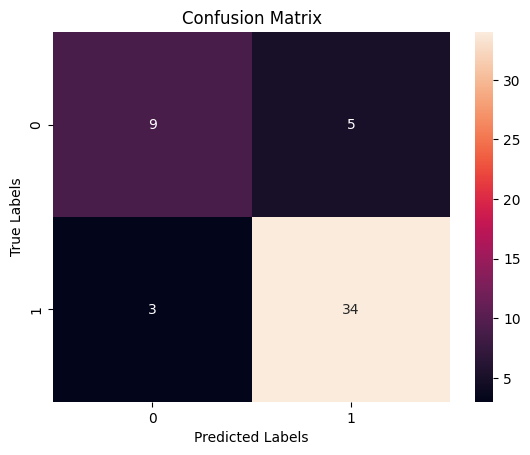

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.64      0.69        14
           1       0.87      0.92      0.89        37

    accuracy                           0.84        51
   macro avg       0.81      0.78      0.79        51
weighted avg       0.84      0.84      0.84        51



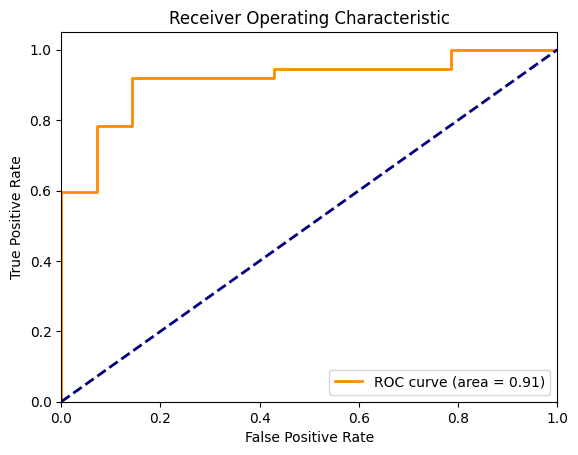

    SubjectId                                               text  True_Labels  \
0  1023041001  Task Results:  Success of Responded to name ,S...            1   
1  1023052034  Task Results:  Success of Responded to name ,S...            1   
2  1023053011  Task Results:  Failure of  ,Failure of  ,Succe...            1   
3  1023061461  Task Results:  Success of Responded to name ,S...            1   
4  1023080172  Task Results:  Failure of  ,Success of Mimicke...            1   

   Predictions              Probabilities  
0            1   [0.29913414, 0.70086586]  
1            1     [0.4416352, 0.5583648]  
2            1    [0.2534121, 0.74658793]  
3            1  [0.019069266, 0.98093075]  
4            1  [0.013637362, 0.98636264]  


In [14]:
# --- Main Script ---

if __name__ == "__main__":
    # set_seed(RANDOM_SEED)

    # # Load and preprocess data
    # train, val, test = load_and_preprocess_data(df_m2)

    # Setup model, tokenizer, and training arguments
    model, tokenizer, training_args = setup_model_and_training_args()

    # Tokenize data
    train_encodings = tokenize_and_pad(tokenizer, train)
    val_encodings = tokenize_and_pad(tokenizer, val)
    test_encodings = tokenize_and_pad(tokenizer, test)

    # Extract SubjectIds
    train_subject_ids = train['SubjectId'].tolist()
    val_subject_ids = val['SubjectId'].tolist()
    test_subject_ids = test['SubjectId'].tolist()

    # Create datasets
    train_dataset = ASD_Dataset(train_encodings, train['label'].tolist(), train_subject_ids)
    val_dataset = ASD_Dataset(val_encodings, val['label'].tolist(), val_subject_ids)
    test_dataset = ASD_Dataset(test_encodings, test['label'].tolist(), test_subject_ids)

    # Initialize Trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics_binary
    )

    # Train the model
    trainer.train()

    # Save the model and tokenizer
    trainer.save_model(SAVE_DIR)
    tokenizer.save_pretrained(SAVE_DIR)

    # Generate predictions on the test set
    predictions_output = trainer.predict(test_dataset)
    predictions = np.argmax(predictions_output.predictions, axis=-1)
    probabilities = softmax(predictions_output.predictions, axis=-1)
    true_labels = predictions_output.label_ids

    # Create a DataFrame for results
    df_results = pd.DataFrame({
        'True_Labels': true_labels,
        'Predictions': predictions,
        'Probabilities': list(probabilities)
    })


    # --- Evaluation and Visualization ---

    # Confusion Matrix
    conf_matrix = confusion_matrix(df_results['True_Labels'], df_results['Predictions'])
    sns.heatmap(conf_matrix, annot=True, fmt='g')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    class_report = classification_report(df_results['True_Labels'], df_results['Predictions'])
    print("Classification Report:\n", class_report)

    # ROC Curve
    y_true = np.array(df_results['True_Labels'])  # Corrected line: Added .array
    y_proba = np.array([proba[1] for proba in df_results['Probabilities']])
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Create a detailed DataFrame with predictions, probabilities, and text
    test_data = [test_dataset[i] for i in range(len(test_dataset))]
    df_test_data = pd.DataFrame(test_data)
    df_test_data['True_Labels'] = true_labels
    df_test_data['Predictions'] = predictions
    df_test_data['Probabilities'] = list(probabilities)

    # Add the original text to the DataFrame
    df_test_data['text'] = test['text'].tolist()

    # Example: Display a few rows with text, predictions, and probabilities
    print(df_test_data[['SubjectId','text', 'True_Labels', 'Predictions', 'Probabilities']].head())

    # (Optional) Save the detailed DataFrame to a CSV
    # df_test_data.to_csv('test_predictions_with_details.csv', index=False)

    # (Optional) Print the training logs
    # print(trainer.state.log_history)